In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# 计算lightGBM+CNNBiLSTM
df_lightGBM = pd.read_csv("./result/lightGBMpre-best.csv")
df_CNNBiLSTM = pd.read_csv("./result/CNN-BiLSTMpre-best.csv")

In [2]:
# 计算基模型的累计误差
def CumMSE(df_model:pd.DataFrame):
    """
    df_model第一列为true，第二列为pre
    """
    cum_mse = []
    for i in range(len(df_model)):
        cum_mse.append(mean_squared_error(df_model.iloc[:i+1,0],df_model.iloc[:i+1,1]))
    return cum_mse

cum_mse_lightGBM = CumMSE(df_lightGBM)
cum_mse_CNNBiLSTM = CumMSE(df_CNNBiLSTM)

# 计算组合权重
def CombineWeight(cum_mse1:list,cum_mse2:list):
    """
    :parameters:
    cum_mse1: 模型1累计误差 
    cum_mse2: 模型2累计误差
    
    :return: 
    模型1的组合权重
    """
    weightList = []
    for i in range(len(cum_mse1)):
        weightOfModel1 = cum_mse1[i]/sum([cum_mse1[i],cum_mse2[i]])
        weightList.append(weightOfModel1)
    return weightList

weight_lightGBM = CombineWeight(cum_mse_lightGBM,cum_mse_CNNBiLSTM)
    

In [4]:
# 计算lightGBM+CNNBiLSTM组合预测值
def CombineModel(df_Model1:pd.DataFrame,df_Model2:pd.DataFrame,combineWeightOfModel1:list):
    """
    :parameters:
    df_Model1: 模型1的结果
    df_Model2: 模型2的结果
    combineWeightOfModel1: 模型1的组合权重

    :return: 预测值
    """
    y_pre = []
    for idx,weight in enumerate(combineWeightOfModel1):
        prediction = df_Model1['y_pre'][idx] *weight + df_Model2['y_pre'][idx]*(1-weight)
        y_pre.append(prediction)
    return y_pre

y_pre = CombineModel(df_lightGBM,df_CNNBiLSTM,weight_lightGBM)
y = df_lightGBM.loc[:,'y_true']


In [5]:
# 计算lightGBM+CNNBiLSTM组合评价
r2Score = r2_score(y_true=y, y_pred=y_pre)
meanSquaredError = mean_squared_error(y_true=y, y_pred=y_pre)
meanAbsoluteError = mean_absolute_error(y_true=y, y_pred=y_pre)
print("r2Score: ", r2Score)
print("meanSquaredError: ", meanSquaredError)
print('RMSE: ',np.sqrt(meanSquaredError))
print("meanAbsoluteError: ", meanAbsoluteError)


r2Score:  0.9874592500114563
meanSquaredError:  0.0006475745566911211
RMSE:  0.025447486254856707
meanAbsoluteError:  0.008720665109818292


In [26]:
import pandas as pd
df_evaluate = pd.read_csv("./result/组合模型结果.csv")
df_evaluate = df_evaluate[(df_evaluate['Port name'] == 'Howth')&(df_evaluate['Model name'] != 'BiLSTM')]

In [27]:
df_evaluate = df_evaluate[['Model name', 'RMSE', 'MAE']].melt(id_vars='Model name')
# df_evaluate

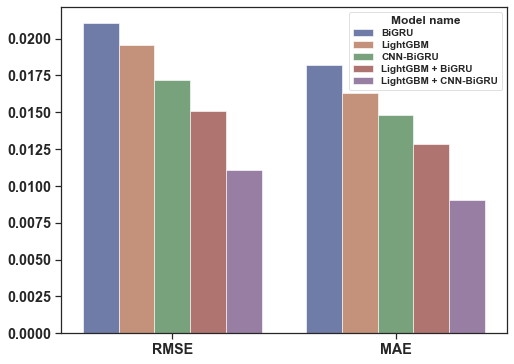

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# 创建画布
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)

sns.set(context='notebook', style='ticks', font_scale=1.3,
rc = {'font.weight':600,'legend.fontsize':10,'legend.title_fontsize':12,
'legend.framealpha':0.6,
'legend.borderpad':     0.4,
'legend.labelspacing':  0.3  })

rc = {"weight":600}
# Draw a nested barplot by species and sex
sns.barplot(
    data=df_evaluate, 
    x="variable"	, y="value", hue="Model name",
    palette="dark", alpha=.6,ax=ax1
)

ax1.set_ylabel('',rc)
ax1.set_xlabel('',rc)

fig.savefig("./plot/compare",dpi=600)